In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

#import string

%matplotlib inline

In [2]:
# Read in the saved files
directory = 'Binned_results/'

files = glob.glob('Binned_results/*20min_073117.csv')
all_frames_lst = []

for file in files:
    frame = pd.read_csv(file)
    all_frames_lst.append(frame)
    
master_raw = pd.concat(all_frames_lst)
master_raw.Period = master_raw.Period / 3 # Convert period to unit of hour

# Convert to actual length units
perch_sep_pix = 230.0 - 60.0 # perch distance in pixels based on image
perch_sep_m = 8.5 / 100 # actual perch distance

master_raw['Activity'] = master_raw.Displacement / perch_sep_pix * perch_sep_m

# Determine genotype

def get_genotype(animal):
    '''Infer the genotype from name of animal'''
    if animal == '2CW318' or animal == 'LB21':
        return 'NA'
    elif '2CW' in animal:
        return 'mut'
    elif 'Z1' in animal:
        return 'Other'
    else:
        return 'WT'
    
def build_gen_dict(animal_lst):
    '''
    Given a list of animal names, use get_genotype
    to return a dict of collections genotype <-> animals of that genotype
    For eg. 'WT' : ['LB2', 'Or130'], 'mut' : ['2CW318', '2CW317']
    '''
    gen_dict = {}
    for animal in animals_lst:
        genotype = get_genotype(animal)
        if genotype not in gen_dict:
            gen_dict[genotype] = [animal]
        else:
            gen_dict[genotype].append(animal)
    return gen_dict
    

master_raw['Genotype'] = master_raw.Animal.apply(get_genotype)

# Exclude days
days_to_exclude = {'2CW318': [3],
                  'LB21': [0],
                  '2CW312': [-1, 0, 1],
                  'LB15': [-1, 0]}

master = master_raw
for animal in days_to_exclude:
    master = master[(master.Animal != animal) | (~master.Day.isin(days_to_exclude[animal]))]

# Get number of animals
animals_lst = pd.Series(master.Animal.unique())
gen_dict = build_gen_dict(animals_lst)
ntotal = animals_lst.shape[0]
n_wt = len(gen_dict['WT'])
n_mut = len(gen_dict['mut'])
n_other = len(gen_dict['Other'])

print 'Total =', ntotal, '. WT =', n_wt, '. Mut =', n_mut, '. Other =', n_other

Total = 17 . WT = 7 . Mut = 6 . Other = 2


In [3]:
# Apply a threshold
master = master[master.Crosses < 1000]

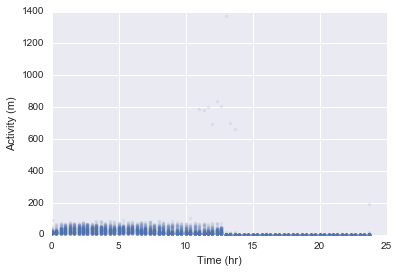

In [4]:
plt.plot(master.Period, master.Activity, '.', alpha=0.1)
plt.xlabel('Time (hr)')
plt.ylabel('Activity (m)')
#plt.ylim((0,200))

In [5]:
# Get 'average line' for wt, mutant, other
def get_statistics(mean_fr):
    '''
    Given the mean data frame, determine the mean line
    and the standard deviation for all time points of each genotype
    Return a tuple (mean, stdev)
    '''
    genotype_mean_fr = mean_fr.groupby(['Genotype', 'Period']).mean()
    genotype_mean_fr = genotype_mean_fr.reset_index()

    # Get standard deviation
    stdev = mean_fr.groupby(['Genotype', 'Period']).std()
    stdev = stdev.reset_index()
    
    return (genotype_mean_fr, stdev)


In [6]:
# Get average activity and crossings for each animal
mean_fr = master.groupby(['Animal','Period']).mean()[['Activity', 'Crosses']]
mean_fr = mean_fr.reset_index()
mean_fr['Genotype'] = mean_fr.Animal.apply(get_genotype)
genotype_mean_fr, stdev = get_statistics(mean_fr)


File saved


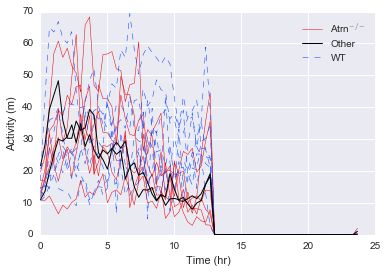

In [7]:
# Define a color palette to use for plots
col_lst = {'WT': sns.color_palette('bright')[0],
          'mut': sns.color_palette('bright')[2],
          'Other': (0, 0, 0)}

# Plot
for animal in mean_fr.Animal.unique():
    animal_fr = mean_fr[mean_fr.Animal == animal]
    if animal in gen_dict['mut']: # mutant
        atrn_line = plt.plot(animal_fr.Period, animal_fr.Activity, 
                             alpha=1, color=col_lst['mut'], lw=0.5)
    elif animal in gen_dict['Other']: # other
        other_line = plt.plot(animal_fr.Period, animal_fr.Activity, 
                           alpha=1, color=col_lst['Other'], lw=1)
    elif animal in gen_dict['WT']: # Wild-type
        wt_line = plt.plot(animal_fr.Period, animal_fr.Activity, '--',
                              alpha=1, color=col_lst['WT'], lw=0.5)
        
plt.xlabel('Time (hr)')
plt.ylabel('Activity (m)')
plt.legend()
plt.legend((atrn_line[0], other_line[0], wt_line[0]), ('Atrn$^{-/-}$','Other','WT'))

# Save the figure
filename = 'Graphs/Python/all_animals_activity_20min_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

File saved


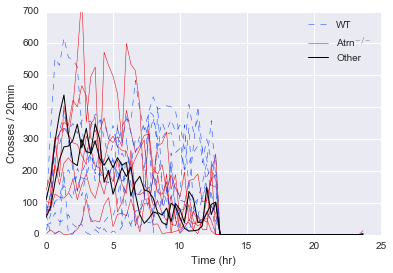

In [8]:
# Plot
for animal in mean_fr.Animal.unique():
    animal_fr = mean_fr[mean_fr.Animal == animal]
    if animal in gen_dict['mut']: # mutant
        atrn_line = plt.plot(animal_fr.Period, animal_fr.Crosses, 
                             alpha=1, color=col_lst['mut'], lw=0.5)
    elif animal in gen_dict['Other']: # other
        other_line = plt.plot(animal_fr.Period, animal_fr.Crosses, 
                           alpha=1, color=col_lst['Other'], lw=1)
    elif animal in gen_dict['WT']: # Wild-type
        wt_line = plt.plot(animal_fr.Period, animal_fr.Crosses, '--',
                              alpha=1, color=col_lst['WT'], lw=0.5)
        
plt.xlabel('Time (hr)')
plt.ylabel('Crosses / 20min')
plt.legend()
plt.legend((wt_line[0], atrn_line[0], other_line[0]), ('WT', 'Atrn$^{-/-}$','Other'))
plt.ylim((0,700))

# Save the figure
filename = 'Graphs/Python/all_animals_Crosses_20min_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

File saved


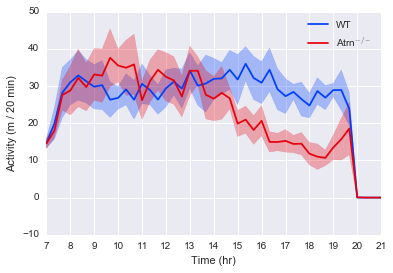

In [9]:
# Plot mean lines for activity
for gtype in ['WT', 'mut']:
    fr = genotype_mean_fr[genotype_mean_fr.Genotype == gtype]
    stdev_genotype = stdev[stdev.Genotype == gtype].Activity
    std_err = stdev_genotype / np.sqrt(len(gen_dict[gtype]))

    plt.plot(fr.Period, fr.Activity, color=col_lst[gtype])
    plt.fill_between(fr.Period, fr.Activity + std_err, fr.Activity - std_err, 
                     alpha=0.3, color=col_lst[gtype])
plt.legend(('WT', 'Atrn$^{-/-}$'))
plt.xlabel('Time (hr)')
plt.xticks(np.arange(24), (np.arange(24) + 7) % 24)
plt.xlim((0, 14))
#plt.xticks(np.arange(24))
plt.ylabel('Activity (m / 20 min)')


filename = 'Graphs/Python/mean_activity_20min_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

File saved


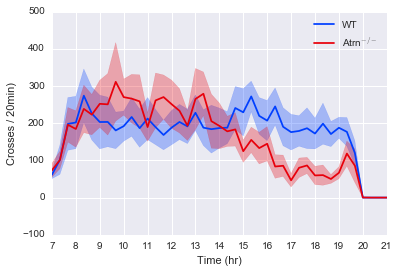

In [10]:
# Plot mean lines for crossings

for gtype in ['WT', 'mut']:
    fr = genotype_mean_fr[genotype_mean_fr.Genotype == gtype]
    stdev_genotype = stdev[stdev.Genotype == gtype].Crosses
    std_err = stdev_genotype / np.sqrt(len(gen_dict[gtype]))

    plt.plot(fr.Period, fr.Crosses, color=col_lst[gtype])
    plt.fill_between(fr.Period, fr.Crosses + std_err, fr.Crosses - std_err, 
                     alpha=0.3, color=col_lst[gtype])
plt.legend(('WT', 'Atrn$^{-/-}$'))
plt.xlabel('Time (hr)')
plt.xticks(np.arange(24), (np.arange(24) + 7) % 24)
#plt.xticks(np.arange(24))
plt.ylabel('Crosses / 20min)')
plt.xlim((0, 14))

filename = 'Graphs/Python/mean_Crosses_20min_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

In [11]:
# Summing the activity from 14h to 19h (corresponding to Zeit from 7 to 12)
mean_fr_afternoon = mean_fr[(mean_fr.Period >= 7) & (mean_fr.Period <= 12)]
total_afternoon_activity = mean_fr_afternoon.groupby(['Animal', 'Genotype']).sum().reset_index()

mean_fr_morning = mean_fr[(mean_fr.Period >= 1) & (mean_fr.Period <= 6) ]
total_morning_activity = mean_fr_morning.groupby(['Animal', 'Genotype']).sum().reset_index()

# For plotting wt/mutant only
total_morning_activity.loc[total_morning_activity.Genotype=='mut', 'Genotype'] = 'Atrn'
total_afternoon_activity.loc[total_afternoon_activity.Genotype=='mut', 'Genotype'] = 'Atrn'

File saved


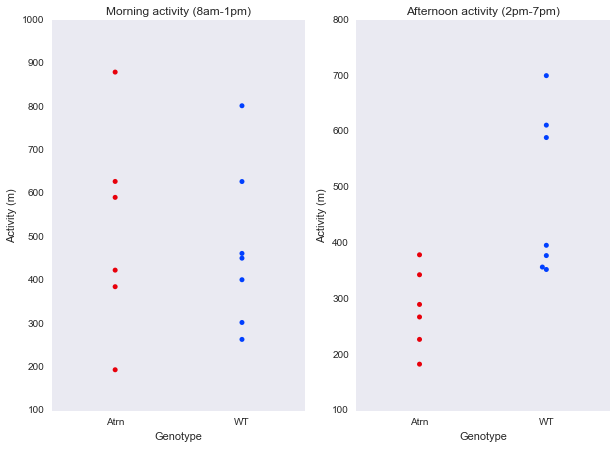

In [12]:
# Plot total morning/afternoon activity
with sns.axes_style('dark'):
    fix, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.swarmplot(data=total_morning_activity[total_morning_activity.Genotype.isin(['Atrn', 'WT'])],
                  x='Genotype', y='Activity', ax=ax[0], palette=[col_lst['mut'], col_lst['WT']])
    ax[0].set_title('Morning activity (8am-1pm)')
    ax[0].set_ylabel('Activity (m)')
    sns.swarmplot(data=total_afternoon_activity[total_afternoon_activity.Genotype.isin(['Atrn', 'WT'])], 
                  x='Genotype', y='Activity', ax=ax[1], palette=[col_lst['mut'], col_lst['WT']])
    ax[1].set_title('Afternoon activity (2pm-7pm)')
    ax[1].set_ylabel('Activity (m)')
    
filename = 'Graphs/Python/morning_afternoon_activity_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

File saved


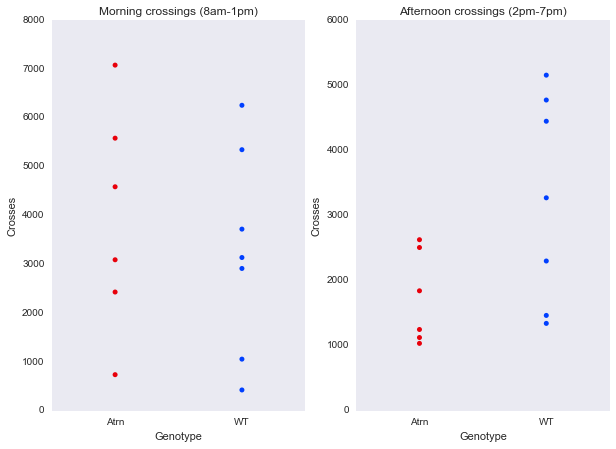

In [35]:
# Plot total morning/afternoon crosses
with sns.axes_style('dark'):
    fix, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.swarmplot(data=total_morning_activity[total_morning_activity.Genotype.isin(['Atrn', 'WT'])],
                  x='Genotype', y='Crosses', ax=ax[0], palette=[col_lst['mut'], col_lst['WT']])
    ax[0].set_title('Morning crossings (8am-1pm)')
    ax[0].set_ylabel('Crosses')
    sns.swarmplot(data=total_afternoon_activity[total_afternoon_activity.Genotype.isin(['Atrn', 'WT'])], 
                  x='Genotype', y='Crosses', ax=ax[1], palette=[col_lst['mut'], col_lst['WT']])
    ax[1].set_title('Afternoon crossings (2pm-7pm)')
    ax[1].set_ylabel('Crosses')
    
filename = 'Graphs/Python/morning_afternoon_crosses_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

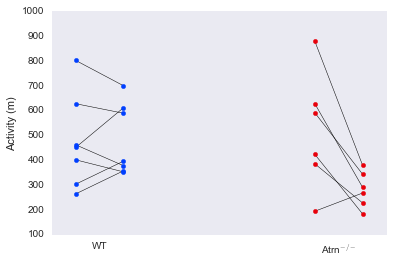

In [14]:
# Paired plots
with sns.axes_style('dark'):
    wt_activity_morning = total_morning_activity[total_morning_activity.Genotype == 'WT'].Activity
    mut_activity_morning = total_morning_activity[total_morning_activity.Genotype == 'Atrn'].Activity
    wt_activity_afternoon = total_afternoon_activity[total_afternoon_activity.Genotype == 'WT'].Activity
    mut_activity_afternoon = total_afternoon_activity[total_afternoon_activity.Genotype == 'Atrn'].Activity
    
    # Plot lines
    for animal in gen_dict['WT']:
        morning_pt = np.array(total_morning_activity[total_morning_activity.Animal == animal].Activity)
        afternoon_pt = np.array(total_afternoon_activity[total_afternoon_activity.Animal == animal].Activity)
        plt.plot([0.9, 1.1], [morning_pt, afternoon_pt], color='black', lw=0.5, zorder=1)
        
    for animal in gen_dict['mut']:
        morning_pt = np.array(total_morning_activity[total_morning_activity.Animal == animal].Activity)
        afternoon_pt = np.array(total_afternoon_activity[total_afternoon_activity.Animal == animal].Activity)
        plt.plot([1.9, 2.1], [morning_pt, afternoon_pt], color='black', lw=0.5, zorder=1)
    
    # Plot points
    plt.scatter(np.ones(len(wt_activity_morning)) - 0.1, wt_activity_morning, 
             color=col_lst['WT'], zorder=2)
    plt.scatter(np.ones(len(mut_activity_morning)) * 2 - 0.1, mut_activity_morning,
             color=col_lst['mut'], zorder=2)
    plt.scatter(np.ones(len(wt_activity_afternoon)) + 0.1, wt_activity_afternoon,
            color=col_lst['WT'], zorder=2)
    plt.scatter(np.ones(len(mut_activity_afternoon)) * 2 + 0.1 , mut_activity_afternoon,
            color=col_lst['mut'], zorder=2)

    plt.ylabel('Activity (m)')
    plt.xticks((1, 2), ('WT', 'Atrn$^{-/-}$'))

# Save the figure
filename = 'Graphs/Python/morning_afternoon_activity_paired_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

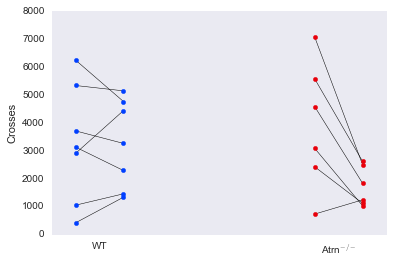

In [15]:
# Paired plots
with sns.axes_style('dark'):
    wt_activity_morning = total_morning_activity[total_morning_activity.Genotype == 'WT'].Crosses
    mut_activity_morning = total_morning_activity[total_morning_activity.Genotype == 'Atrn'].Crosses
    wt_activity_afternoon = total_afternoon_activity[total_afternoon_activity.Genotype == 'WT'].Crosses
    mut_activity_afternoon = total_afternoon_activity[total_afternoon_activity.Genotype == 'Atrn'].Crosses
    
    # Plot lines
    for animal in gen_dict['WT']:
        morning_pt = np.array(total_morning_activity[total_morning_activity.Animal == animal].Crosses)
        afternoon_pt = np.array(total_afternoon_activity[total_afternoon_activity.Animal == animal].Crosses)
        plt.plot([0.9, 1.1], [morning_pt, afternoon_pt], color='black', lw=0.5, zorder=1)
        
    for animal in gen_dict['mut']:
        morning_pt = np.array(total_morning_activity[total_morning_activity.Animal == animal].Crosses)
        afternoon_pt = np.array(total_afternoon_activity[total_afternoon_activity.Animal == animal].Crosses)
        plt.plot([1.9, 2.1], [morning_pt, afternoon_pt], color='black', lw=0.5, zorder=1)
    
    # Plot points
    plt.scatter(np.ones(len(wt_activity_morning)) - 0.1, wt_activity_morning, 
             color=col_lst['WT'], alpha=1, zorder=2)
    plt.scatter(np.ones(len(mut_activity_morning)) * 2 - 0.1, mut_activity_morning,
             color=col_lst['mut'], alpha=1, zorder=2)
    plt.scatter(np.ones(len(wt_activity_afternoon)) + 0.1, wt_activity_afternoon,
            color=col_lst['WT'], alpha=1, zorder=2)
    plt.scatter(np.ones(len(mut_activity_afternoon)) * 2 + 0.1 , mut_activity_afternoon,
            color=col_lst['mut'], alpha=1, zorder=2)

    plt.ylabel('Crosses')
    plt.xticks((1, 2), ('WT', 'Atrn$^{-/-}$'))

# Save the figure
filename = 'Graphs/Python/morning_afternoon_crosses_paired_080117.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
    print 'File saved'

In [16]:
def ind_animal_plot(master, name, exclude=[]):
    fr = master[(master.Animal == name) & (~master.Day.isin(exclude))]
    for day in fr.Day.unique():
        subfr = fr[fr.Day == day]
        plt.plot(subfr.Period, subfr.Activity, alpha=0.3, label='Day' + str(day))

    # Plot the mean line
    mean_animal_fr = fr.groupby('Period').mean()
    mean_animal_fr = mean_animal_fr.reset_index()
    plt.plot(mean_animal_fr.Period, mean_animal_fr.Activity, '--', 
             color='black', label='Mean')
    
    #plt.ylim((0, 80))

    plt.xlabel('Time (hour)')
    plt.ylabel('Activity (m / 20min)')
    plt.legend()

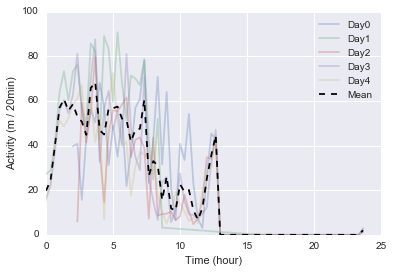

In [17]:
ind_animal_plot(master, '2CW100', exclude=[])

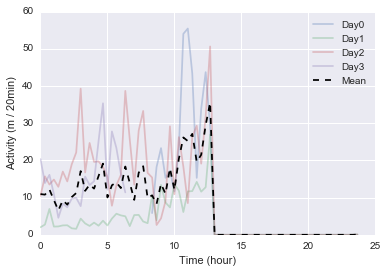

In [18]:
ind_animal_plot(master, '2CW305', exclude=[])

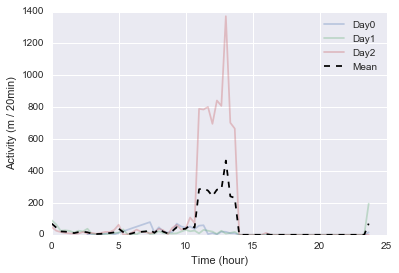

In [19]:
ind_animal_plot(master, '2CW318', exclude=[3])

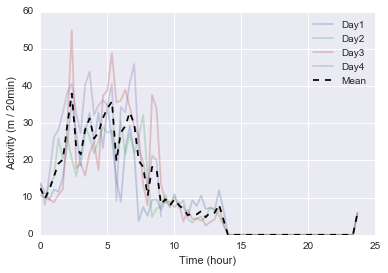

In [20]:
ind_animal_plot(master, 'LB21', exclude=[])

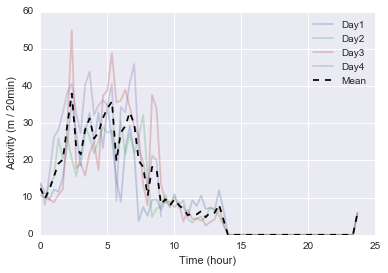

In [21]:
ind_animal_plot(master_raw, 'LB21', exclude=[0])

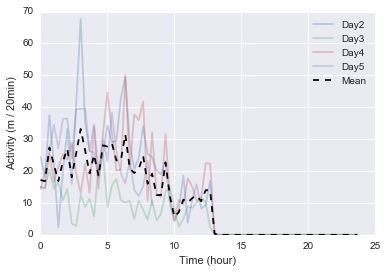

In [22]:
ind_animal_plot(master, '2CW312', exclude=[])

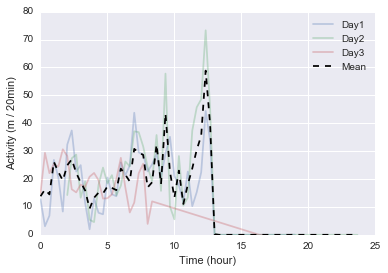

In [23]:
ind_animal_plot(master, 'LB15', exclude=[])

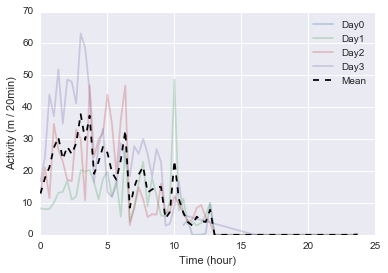

In [24]:
ind_animal_plot(master, '2CW306', exclude=[])

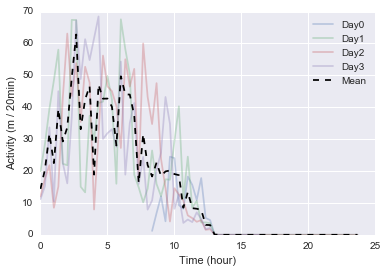

In [25]:
ind_animal_plot(master, '2CW308', exclude=[])

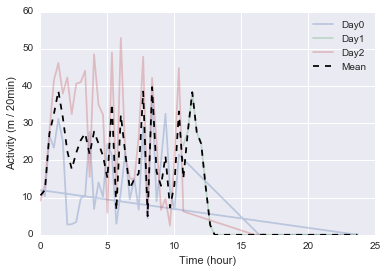

In [26]:
ind_animal_plot(master, 'LB06', exclude=[])

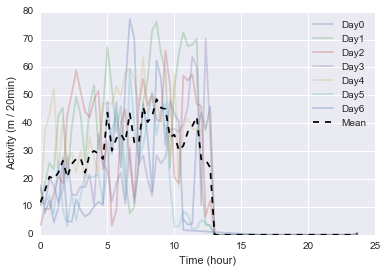

In [27]:
ind_animal_plot(master, 'Or130', exclude=[])

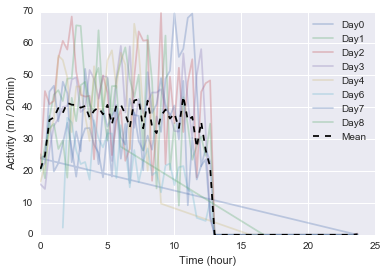

In [28]:
ind_animal_plot(master, 'Or114', exclude=[])

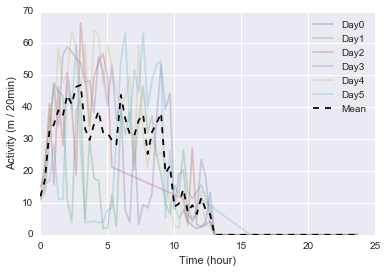

In [29]:
ind_animal_plot(master, '2CW317', exclude=[])

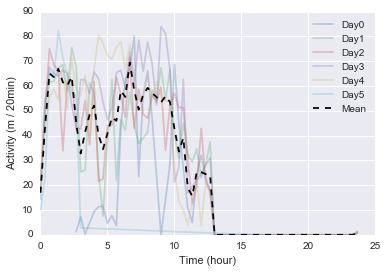

In [30]:
ind_animal_plot(master, 'LB2', exclude=[])

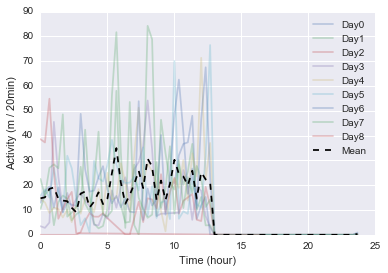

In [31]:
ind_animal_plot(master, 'LB11', exclude=[])

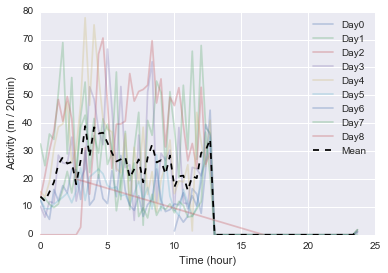

In [32]:
ind_animal_plot(master, 'Or128', exclude=[])

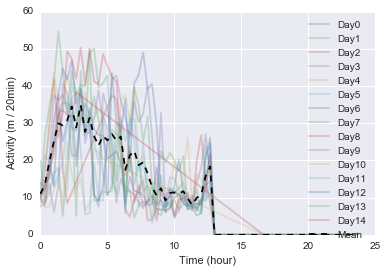

In [33]:
ind_animal_plot(master, 'Z1Pi229', exclude=[])

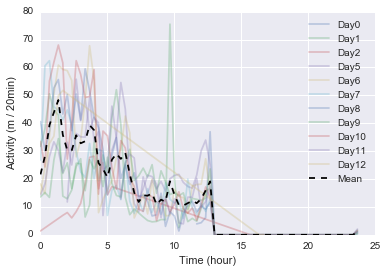

In [34]:
ind_animal_plot(master, 'Z1Pi230', exclude=[])